In [7]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from pathlib import Path

import numpy as np

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.optimization_data import TrainingData, PredictionData
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_6
WEIGHTING = "value_weighted"

## 1.1

In [9]:
portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / Dataset.FACTORS,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

## 1.2

In [10]:
from wufam.strategies.heuristics.equally_weighted import EWStrategy
from wufam.strategies.estimated.mean_var import MeanVariance
from wufam.strategies.estimated.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

ew_strategy = EWStrategy()

In [11]:
from wufam.estimation.mean.sample_mu_estimator import SampleMuEstimator
from wufam.estimation.covariance.sample_cov_estimator import SampleCovEstimator

mv_strategy = MeanVariance(
    mu_estimator=SampleMuEstimator(),
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [12]:
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

# trading_config_min_var = TradingConfig(total_exposure=1, min_exposure=0.0)

min_var_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(alphas=np.linspace(0.0, 1.0, 100)),
    # cov_estimator=LedoitWolfCVCovEstimator(),
    # trading_config=trading_config_min_var,
    trading_config=trading_config,
    window_size=None,
)

In [13]:
training_data = TrainingData(
    simple_excess_returns=portfolios_xs_r,
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

In [14]:
prediction_data = PredictionData()

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [15]:
ew_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [16]:
mv_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,-2.914401,2.713937,1.02806,1.605151,-1.028673,-0.404073


In [17]:
min_var_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,-0.671276,0.681026,0.361899,0.476674,0.577262,-0.425585


In [18]:
min_var_strategy.cov_estimator.best_alpha

np.float64(0.020202020202020204)

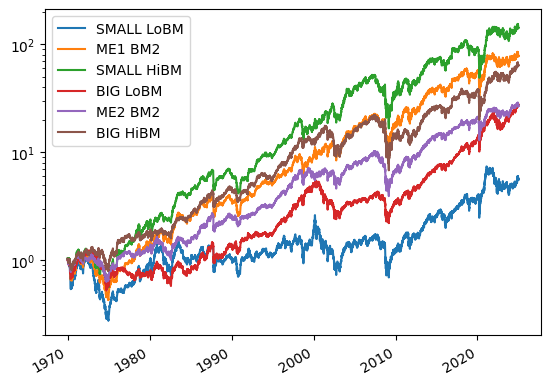

In [19]:
portfolios_xs_r.add(1).cumprod().plot(logy=True);

In [20]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=252,
)

0.4629649799815216

In [21]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=252,
)

0.5620564006405585

In [22]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=252,
)

0.611169793800908

## 1.3.

In [23]:
split_date = portfolios_xs_r.index[len(portfolios_xs_r) // 2]

training_data = TrainingData(
    simple_excess_returns=portfolios_xs_r.loc[:split_date],
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [24]:
min_var_strategy.cov_estimator.best_alpha

np.float64(0.0)

In-sample.

In [25]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

0.4651515142590495

In [26]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

1.1215682199695207

In [27]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

1.0772818557320734

Out-of-sample.

In [28]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.04726382910935625

In [29]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.1821874078413307

In [30]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.1828328121833465

Factor => Doesn't improve, as should've shorted

## 1.4

In [31]:
from wufam.metrics.grs_test import GRSTest

grs_test_capm = GRSTest()
grs_test_capm.fit(
    rets_df=portfolios_xs_r,
    factors_df=factors_df[["Mkt-RF"]],
)

In [32]:
grs_test_capm.grs_stat, grs_test_capm.p_value

(np.float64(8.621724017012603), np.float64(2.201415323319591e-09))

Try monthly

In [33]:
from wufam.metrics.grs_test import GRSTest

grs_test_ff = GRSTest()
grs_test_ff.fit(
    rets_df=portfolios_xs_r,
    factors_df=factors_df,
)

In [34]:
grs_test_ff.grs_stat, grs_test_ff.p_value

(np.float64(14.01045314262867), np.float64(5.792140688748753e-16))

In [35]:
long_columns = [col for col in portfolios_xs_r.columns if "HiBM" in col]
short_columns = [col for col in portfolios_xs_r.columns if "LoBM" in col]

repl = portfolios_xs_r[long_columns].mean(axis=1) - portfolios_xs_r[short_columns].mean(
    axis=1
)

In [36]:
np.abs(factors_df["HML"].to_numpy() - repl.round(4).to_numpy()).mean()

np.float64(3.854804988825617e-05)

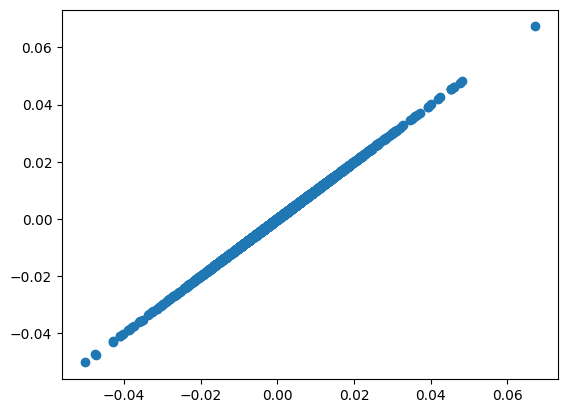

In [37]:
import matplotlib.pyplot as plt

plt.scatter(factors_df["HML"].to_numpy(), repl.round(4).to_numpy());

In [38]:
np.corrcoef(factors_df["HML"].to_numpy(), repl.round(4).to_numpy())

array([[1.        , 0.99994896],
       [0.99994896, 1.        ]])

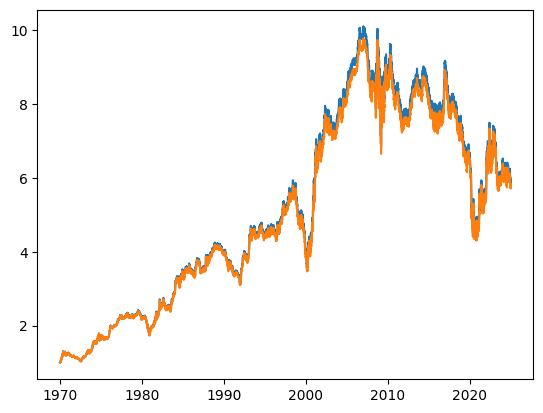

In [40]:
plt.plot(factors_df["HML"].add(1).cumprod())
plt.plot(repl.round(4).add(1).cumprod())
plt.show()